In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Neural Network - With Target Encoded Feature
Neural network plus the mean encoded feature

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras.metrics as km

In [6]:
from sba_gnn.sba_gnn import sg_plot 

## Input Data

In [7]:
business_data = pd.read_parquet(Path(setup.temp_path).joinpath('20_DATA_combined_scaled_all.parquet'))

In [8]:
with open(Path(setup.temp_path).joinpath('20_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [9]:
features = [f for f in imputer_features if 'NAICS' not in f]
features = features + ['mhier_NAICS']
print(features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag', 'mhier_NAICS']


##### Datasets for train, validation

In [10]:
X = business_data[['dset', 'LoanNr_ChkDgt'] + features].set_index('LoanNr_ChkDgt').sort_index()

In [11]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = business_data[business_data['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (436120, 11), y:(436120,)


In [12]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = business_data[business_data['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (93454, 11), y:(93454,)


In [13]:
base_thresh = y_train.mean()
print(base_thresh)

0.2046546821975603


## Function to create model

In [14]:
def create_model(n_feat = len(features), 
                 hidden_size = setup.nn_layer_sizes,
                 activation='tanh', lr=setup.nn_learning_rate,
                 opt_func = setup.nn_optimizer, dropout = setup.nn_dropout):
    
    n_layers = len(hidden_size)
    model = Sequential()
    model.add(Dense(hidden_size[0], input_shape=(n_feat,), activation=activation))
    for i in range(1, n_layers):
        model.add(Dropout(dropout))
        model.add(Dense(hidden_size[i], input_shape=(hidden_size[i-1],), activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = opt_func(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC')])
    return model

## Create, fit model

In [15]:
this_model = create_model()

2024-03-29 14:18:48.109617: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-29 14:18:48.109645: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-29 14:18:48.109651: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-29 14:18:48.109690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-29 14:18:48.109707: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
this_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9857 (38.50 KB)
Trainable params: 9857 (38.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
this_history = this_model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs)

Epoch 1/20


2024-03-29 14:18:48.790301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13629/13629 [==============================] - ETA: 0s - loss: 0.4667 - auc: 0.3361 - auc_1: 0.6964

2024-03-29 14:22:53.789551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13629/13629 [==============================] - 276s 20ms/step - loss: 0.4667 - auc: 0.3361 - auc_1: 0.6964 - val_loss: 0.4676 - val_auc: 0.3642 - val_auc_1: 0.7130
Epoch 2/20
13629/13629 [==============================] - 253s 19ms/step - loss: 0.4587 - auc: 0.3576 - auc_1: 0.7133 - val_loss: 0.4663 - val_auc: 0.3693 - val_auc_1: 0.7169
Epoch 3/20
13629/13629 [==============================] - 307s 23ms/step - loss: 0.4568 - auc: 0.3637 - auc_1: 0.7172 - val_loss: 0.4609 - val_auc: 0.3714 - val_auc_1: 0.7183
Epoch 4/20
13629/13629 [==============================] - 300s 22ms/step - loss: 0.4561 - auc: 0.3662 - auc_1: 0.7189 - val_loss: 0.4591 - val_auc: 0.3738 - val_auc_1: 0.7197
Epoch 5/20
13629/13629 [==============================] - 251s 18ms/step - loss: 0.4556 - auc: 0.3688 - auc_1: 0.7198 - val_loss: 0.4596 - val_auc: 0.3760 - val_auc_1: 0.7207
Epoch 6/20
13629/13629 [==============================] - 1702s 125ms/step - loss: 0.4552 - auc: 0.3687 - auc_1: 0.7204 - val_loss: 0.46

In [18]:
this_history_df = pd.DataFrame(this_history.history)

In [19]:
# Rename columns
try:
    this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                               if re.search(r'_\d+$', c) else c for c in this_history_df.columns]
except:
    pass
try:
    cur_col = list(this_history_df.columns)
    this_history_df.columns = [cur_col[0]] + \
        [f'{cur_col[i]}_roc'  if (cur_col[i] == cur_col[i-1]) and 'auc'in cur_col[i] \
         else cur_col[i] for i in range(1, len(cur_col))]
except:
    pass

In [20]:
this_history_df.columns

Index(['loss', 'auc', 'auc_roc', 'val_loss', 'val_auc', 'val_auc_roc'], dtype='object')

In [21]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('24_REPORT_fit_history.csv'))

<Axes: >

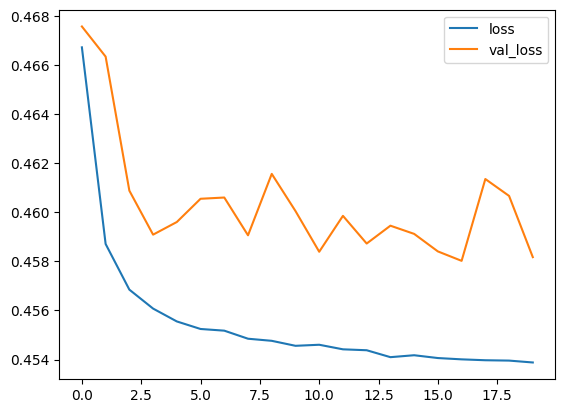

In [22]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

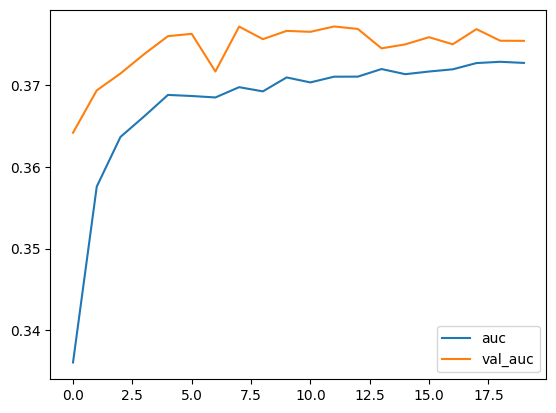

In [23]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

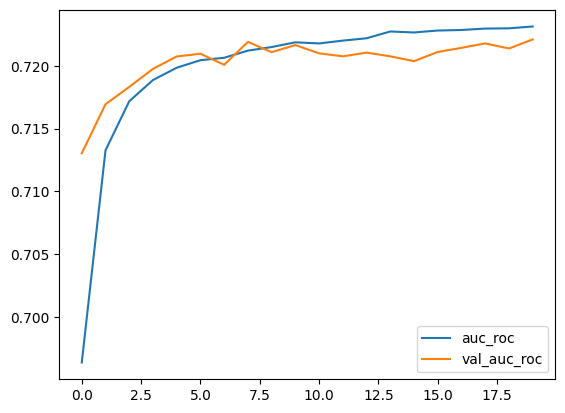

In [24]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [25]:
this_model.save(Path(setup.temp_path).joinpath('24_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [26]:
all_predictions = this_model.predict(X.drop(columns='dset'))

   56/21503 [..............................] - ETA: 1:00

2024-03-29 21:47:33.376351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 47s 2ms/step


In [27]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(business_data[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout']], on='LoanNr_ChkDgt')
    

In [28]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.316694
target,0.316694,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [29]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [30]:
thresh_tune_data = sg_plot.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [31]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
12,0.24,0.449937
11,0.22,0.448631
13,0.26,0.448313


In [32]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.24

##### Append binary predictions to probability predictions

In [33]:
all_predictions_df['predict_bin'] = sg_plot.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [34]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.566076
1    0.433924
Name: proportion, dtype: float64

In [35]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('24_DATA_predictions.parquet'))

## Metrics

In [36]:
all_predictions_df = pd.read_parquet(Path(setup.temp_path).joinpath('24_DATA_predictions.parquet'))

In [37]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('24_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.658028,0.441272,0.324461,0.689505,0.368993,0.728764,NaN
1,train,0.645838,0.449937,0.329797,0.707767,0.380263,0.727729,NaN
2,val,0.642830,0.447816,0.329648,0.698040,0.375442,0.722100,NaN
0,test,0.643015,0.447923,0.328439,0.704052,0.375652,0.724727,0.0
1,test,0.679595,0.430286,0.317840,0.665849,0.359838,0.732317,1.0


## Embeddings
Save the hidden layer weight prior to sigmoid output, for possible later use in unsupervised GNN 

In [38]:
embed_model = Model(inputs=this_model.inputs, outputs=this_model.layers[-2].output) 

In [39]:
embed_out = embed_model.predict(X.drop(columns='dset'))

  109/21503 [..............................] - ETA: 30s

2024-03-29 21:48:56.102575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 30s 1ms/step


In [40]:
embed_out.shape

(688081, 64)

In [41]:
embed_df = pd.DataFrame(embed_out, index=X.index) 
embed_df.columns = [f'emb_{i:03d}' for i in range(len(embed_df.columns))]
embed_df.reset_index(inplace=True)

In [42]:
embed_df.head()

,LoanNr_ChkDgt,emb_000,emb_001,emb_002,emb_003,emb_004,emb_005,emb_006,emb_007,emb_008,...,emb_054,emb_055,emb_056,emb_057,emb_058,emb_059,emb_060,emb_061,emb_062,emb_063
0,1000014003,-0.725175,-0.999735,0.999895,-0.999975,-0.625319,0.282910,0.677266,0.999937,0.917911,...,-1.000000,-0.474201,-0.860358,0.999858,1.000000,-0.999961,0.937080,0.999444,0.520372,0.999997
1,1000024006,-0.961287,-0.999914,0.999992,-0.999995,-0.348542,-0.444216,0.914527,0.999921,0.415091,...,-1.000000,0.903678,-0.501202,0.999997,1.000000,-0.999917,0.980018,0.999807,0.629740,0.999969
2,1000034009,-0.996844,0.999340,0.185634,-0.992232,0.749023,-0.911952,0.810983,0.999998,-0.600136,...,-0.999982,0.820722,-0.886196,-0.979299,0.999939,-0.999999,0.430967,0.999446,-0.999596,0.999998
3,1000084002,-0.993791,0.999819,-0.407227,-0.994009,0.717100,-0.847271,0.763597,0.999999,-0.248536,...,-0.999992,0.061989,-0.947672,-0.997339,0.999821,-0.999999,0.496669,0.999282,-0.999877,0.999999
4,1000094005,-0.962998,-0.999892,0.999985,-0.999992,-0.388367,-0.834623,0.910630,0.999833,0.689091,...,-1.000000,0.937847,0.243599,0.999996,1.000000,-0.999905,0.961322,0.999786,0.731654,0.999979


In [43]:
embed_df.to_parquet(Path(setup.temp_path).joinpath('24_DATA_embeddings.parquet'))